In [11]:
from PyMouSh import MoulinShape, TimeStamps, Qin_sinusoidal, Qin_real
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import os

secinday = 24*3600
ZERO_KELVIN = 273.15
timestep = 300
supraglacial_baseflow = 0.1

def find_nearest_idx(array, value):
    """Finds the nearest value in an array and outputs a index.
    This function was found in 
    https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array

    Parameters:
    -----------
    array: array to be looked into
    value: single value to look for into the array

    Output:
    -------
    index of the closest value in the array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def Fill_dict(Q_csv_name,head_csv_name,timestep):
    dictionnary = defaultdict(list)
    
    tmp1 = pd.read_csv(Q_csv_name)
    tmp1 = tmp1.dropna()
    Qin = tmp1.Qm3s.to_numpy() + supraglacial_baseflow
    Qtime = tmp1.SOY.to_numpy()
        
    #time array in seconds
    dictionnary['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],timestep)
    dictionnary['meltwater_data'] = Qin_real(dictionnary['meltwater_time'], Qin, Qtime)
    
    tmp2 = pd.read_csv(head_csv_name)
    tmp2 = tmp2.dropna()
    dictionnary['h_real'] = tmp2.head_bed.to_numpy()
    dictionnary['t_real'] = tmp2.soy.to_numpy()
    return dictionnary

#def Fill_dict_real(head_csv_name):
#    dictionnary = defaultdict(list)
#    tmp2 = pd.read_csv(head_csv_name)
#    tmp2 = tmp2.dropna()
#    dictionnary['h_real'] = tmp2.head_bed.to_numpy()
#    dictionnary['t_real'] = tmp2.soy.to_numpy()
#    return dictionnary


#temperature profile -- same for all
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy() #np.array([ZERO_KELVIN, ZERO_KELVIN])#

#field data dictionnaries
#tmp = pd.read_csv('Field_Data/surface_discharge_andrews2014_1h_smooth.csv')
#tmp = tmp.dropna()

#m3 = Fill_dict_real('Field_Data/head_m3.csv')
#Qin = tmp.m3_m3s_1h_24hS.to_numpy() + supraglacial_baseflow
#Qin[Qin<0]=0
#Qtime = tmp.UTC_SOY_1h.to_numpy()
#m3['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],300)
#m3['meltwater_data'] = Qin_real(m3['meltwater_time'], Qin, Qtime)

#m4 = Fill_dict_real('Field_Data/head_m4.csv')
#Qin = tmp.m4_m3s_1h_24hS.to_numpy() + supraglacial_baseflow
#Qin[Qin<0]=0
#Qtime = tmp.UTC_SOY_1h.to_numpy()
#m4['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],300)
#m4['meltwater_data'] = Qin_real(m3['meltwater_time'], Qin, Qtime)

#foxx = Fill_dict_real('Field_Data/head_mf.csv')
#Qin = tmp.mF_m3s_1h_24hS.to_numpy() + supraglacial_baseflow
#Qin[Qin<0]=0
#Qtime = tmp.UTC_SOY_1h.to_numpy()
#foxx['meltwater_time'] = TimeStamps(Qtime[0],Qtime[-1],300)
#foxx['meltwater_data'] = Qin_real(m3['meltwater_time'], Qin, Qtime)

jeme = Fill_dict('Field_Data/surface_melt_jeme.csv','Field_Data/head_jeme.csv',timestep)
pira = Fill_dict('Field_Data/surface_melt_pira.csv','Field_Data/head_pira.csv',timestep)
radi = Fill_dict('Field_Data/surface_melt_radi.csv','Field_Data/head_radi.csv',timestep)
m3 = Fill_dict('Field_Data/surface_melt_m3.csv','Field_Data/head_m3.csv',timestep)
m4 = Fill_dict('Field_Data/surface_melt_m4.csv','Field_Data/head_m4.csv',timestep)

#glacier properties (from readme)
m3['ice_thickness'] = 560
m4['ice_thickness'] = 540
#foxx['ice_thickness'] = 620
jeme['ice_thickness'] = 500
pira['ice_thickness'] = 500
radi['ice_thickness'] = 700

jeme['baseflow_one'] = np.ones(len(jeme['meltwater_time']))
pira['baseflow_one'] = np.ones(len(pira['meltwater_time']))
radi['baseflow_one'] = np.ones(len(radi['meltwater_time']))
m3['baseflow_one'] = np.ones(len(m3['meltwater_time']))
m4['baseflow_one'] = np.ones(len(m4['meltwater_time']))
#foxx['baseflow_one'] = np.ones(len(foxx['meltwater_time']))

m3['name'] = 'M3'
m4['name'] = 'M4'
#foxx['name'] = 'FOXX'
jeme['name'] = 'JEME'
pira['name'] = 'PIRA'
radi['name'] = 'RADI'

m3['time_lim'] = [150,250]
m4['time_lim'] = [150,250]
#foxx['time_lim'] = [150,250]
jeme['time_lim'] = [182,250]
pira['time_lim'] = [200,250]
radi['time_lim'] = [208,250]

#surface slope from hoffman 2016 supplemental

def calc_and_make1plot( dataset,
                        initial_subglacial_area = (np.pi*0.75**2)/2,
                        fluidity_coefficient_SUB = 6e-24,
                        channel_length = 25000,
                        creep_factor = 3, 
                        baseflow = 0, 
                        friction = 0.1,
                        regional_surface_slope = 0.01,
                        delay = -5*3600,
                        path = 'figure_movie_AGU/',
                        make_directory = False,
                        min_radius = 0.1,
                        make_all_plots = False,
                        creep=True,
                        elastic_deformation=True,
                        melt_below_head=True,
                        ice_motion=True,
                        z_elevations = None,
                        moulin_radii = 0.2,
                        dir_name = None
                        ): 
    
    params =  dataset['name']+'_baseflow%d'%baseflow + '_channel%d'%channel_length + '_creep%d'%creep_factor + '_friction%e.1'%friction + 'fluidity_coefficient_SUB%e.1'%fluidity_coefficient_SUB 
    if make_directory == True:
        #directory = dataset['name'] + params + '/'
        if os.path.isdir(path+dir_name) == False:           
            os.mkdir(path + dir_name)
    moulin_sim = MoulinShape(channel_length = channel_length,
                            temperature_profile = temperature_profile,                   
                            ice_thickness = dataset['ice_thickness'],
                            regional_surface_slope = regional_surface_slope,
                            initial_subglacial_area = initial_subglacial_area, 
                            friction_factor_SUB = friction,
                            creep_enhancement_factor = creep_factor,
                            fluidity_coefficient_SUB = fluidity_coefficient_SUB,
                            z_elevations = z_elevations,
                            moulin_radii = moulin_radii
                            )

    portion = (dataset['meltwater_time'] > dataset['time_lim'][0]*secinday) & (dataset['meltwater_time'] < dataset['time_lim'][1]*secinday)
    time = dataset['meltwater_time'][portion]
    time_plot = np.arange(time[0],time[-1],1*3600) #plot every hour


    #calculate simulation
    for idx,t in enumerate(time):
        meltwater = dataset['meltwater_data'][dataset['meltwater_time']==t]
        moulin_sim.run1step(t,timestep,meltwater,
                            subglacial_baseflow = baseflow,
                            potential_drop=False,
                            open_channel_melt=True,
                            creep=creep,
                            elastic_deformation=elastic_deformation,
                            melt_below_head=melt_below_head,
                            ice_motion=ice_motion,
                            min_radius = min_radius
                            )

    #plot simulation
    if make_all_plots == True:
        for idx,t_end in enumerate(time_plot):              
            t_start = t_end-time_plot[-1]+time_plot[0]
            fig = plt.figure(figsize=(13,5),dpi=150)
            fig.suptitle(dataset['name'], fontsize=16)
            moulin_sim.plot_AGU_4(fig,t_start, t_end,
                                 dataset['t_real']+delay,dataset['h_real'],
                                 spine_head_min=200,
                                 ground_depth=-60,
                                 Q_lim = [min(dataset['meltwater_data']),max(dataset['meltwater_data'])],
                                 SC_lim = [min(moulin_sim.dict['subglacial_radius']),max(moulin_sim.dict['subglacial_radius'])],
                                 display_baseflow = False)

            plt.savefig(path + dir_name + '/'+ 'img%d.png'%idx)
            plt.clf()
            plt.close(fig)
            #del fig
    else:
        t_end = time[-1]
        t_start = t_end-time[-1]+time[0]
        fig = plt.figure(figsize=(13,5),dpi=150)
        fig.suptitle(dataset['name'], fontsize=16)
        moulin_sim.plot_AGU_4(fig,t_start, t_end,
                             dataset['t_real']+delay,dataset['h_real'],
                             spine_head_min=200,
                             ground_depth=-60,
                             Q_lim = [min(dataset['meltwater_data']),max(dataset['meltwater_data'])],
                             SC_lim = [min(moulin_sim.dict['subglacial_radius']),max(moulin_sim.dict['subglacial_radius'])],
                             display_baseflow = False)
        plt.savefig(path + params + '_no%d.png'%idx)
        
    return moulin_sim, params,time
    
    




In [28]:
make_all_plots = True
make_directory = True
m3_brut, params_m3_brut, time_m3_brut= calc_and_make1plot(m3,
                                                       initial_subglacial_area = (np.pi*0.5**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       delay = 24*3600,
                                                       dir_name = 'm3_brut')

/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 150.00347222222223 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 150.00347222222223 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 150.00347222222223 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


In [29]:
make_all_plots = True
make_directory = True
m3_bf, params_m3_bf, time_m3_bf= calc_and_make1plot(m3,
                                                       initial_subglacial_area = (np.pi*2.25**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       baseflow = 15, 
                                                       delay = 24*3600,
                                                       channel_length = 50000,
                                                       dir_name = 'm3_bf')

/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 150.00347222222223 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 150.00347222222223 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 150.00347222222223 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


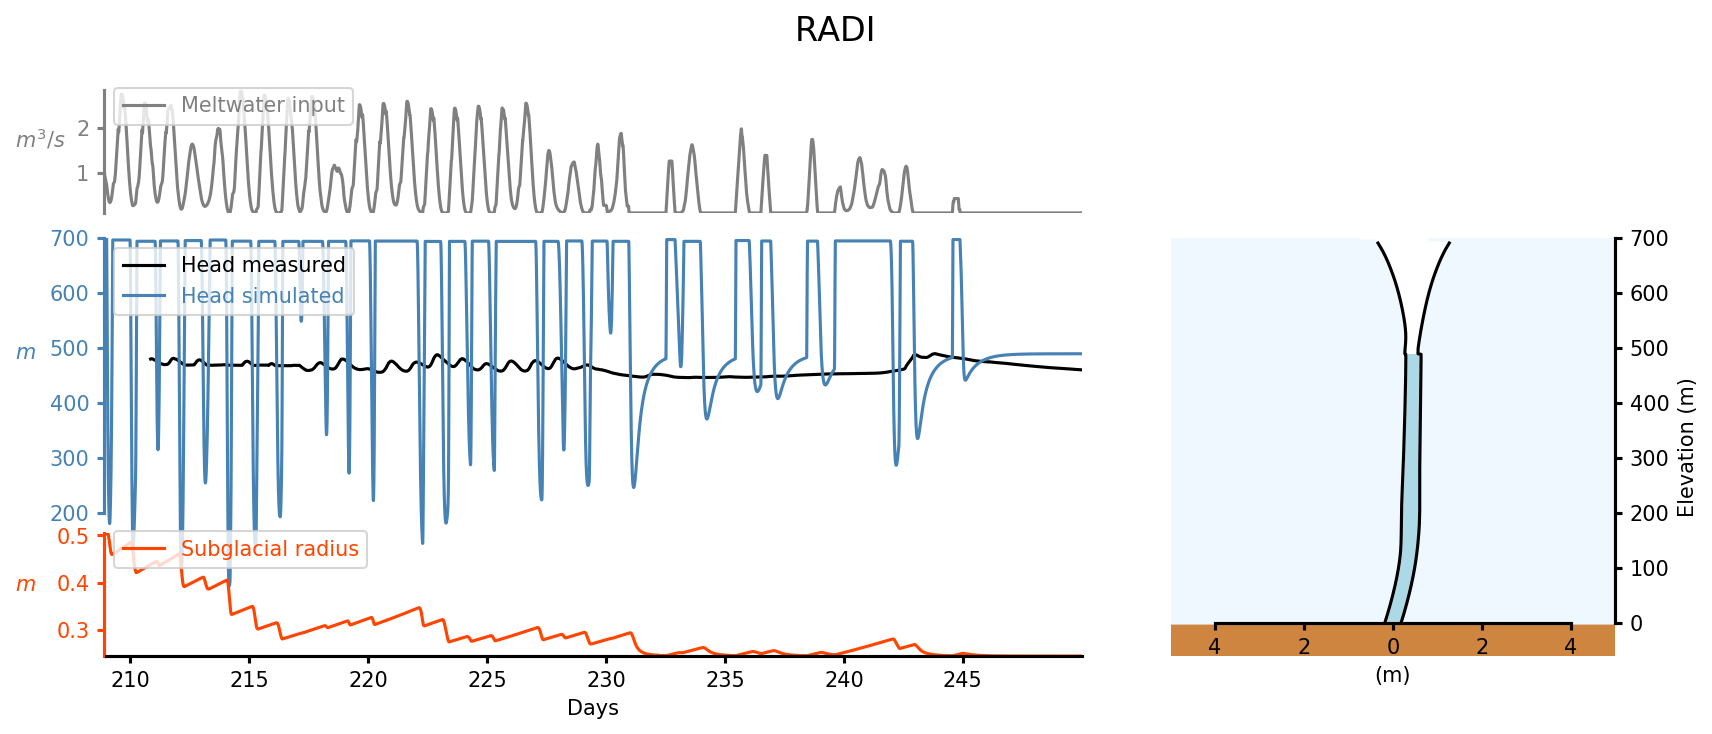

In [20]:
make_all_plots = False
make_directory = False
radi_brut, params_radi_brut, time_radi_brut= calc_and_make1plot(radi,
                                                       initial_subglacial_area = (np.pi*0.5**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       delay = 24*3600,
                                                       dir_name = 'radi_brut')

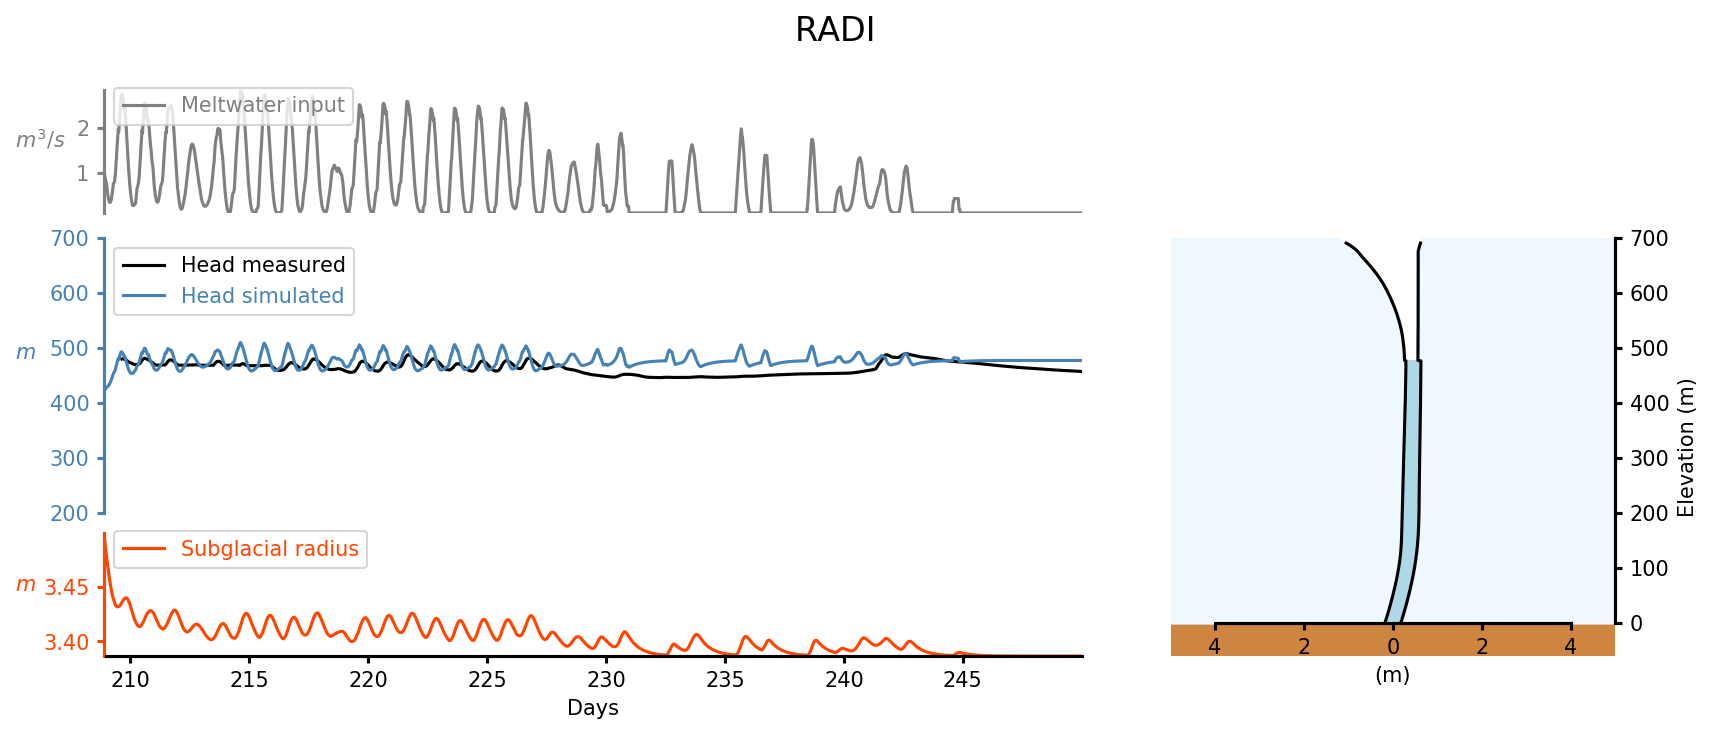

In [23]:
make_all_plots = False
make_directory = False
radi_bf, params_radi_bf, time_radi_bf= calc_and_make1plot(radi,
                                                       initial_subglacial_area = (np.pi*3.5**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       baseflow = 50,
                                                       channel_length = 50000,
                                                       dir_name = 'radi_bf')

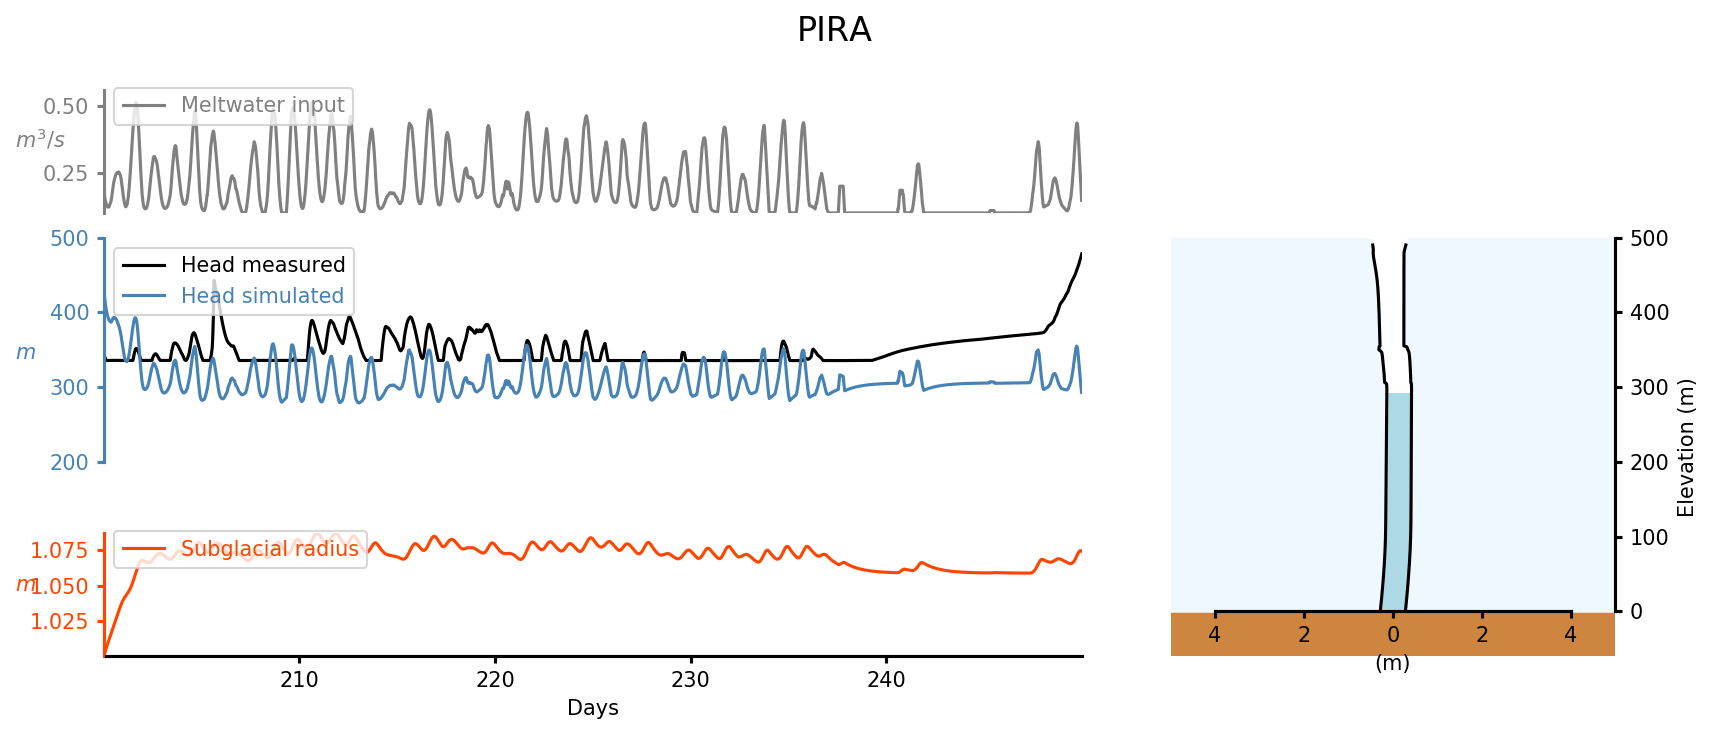

In [27]:
make_all_plots = False
make_directory = False
pira_bf, params_pira_bf, time_pira_bf= calc_and_make1plot(pira,
                                                       initial_subglacial_area = (np.pi*1**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       baseflow = 3,
                                                       dir_name = 'pira_bf')

### Make simulations based on observed topo

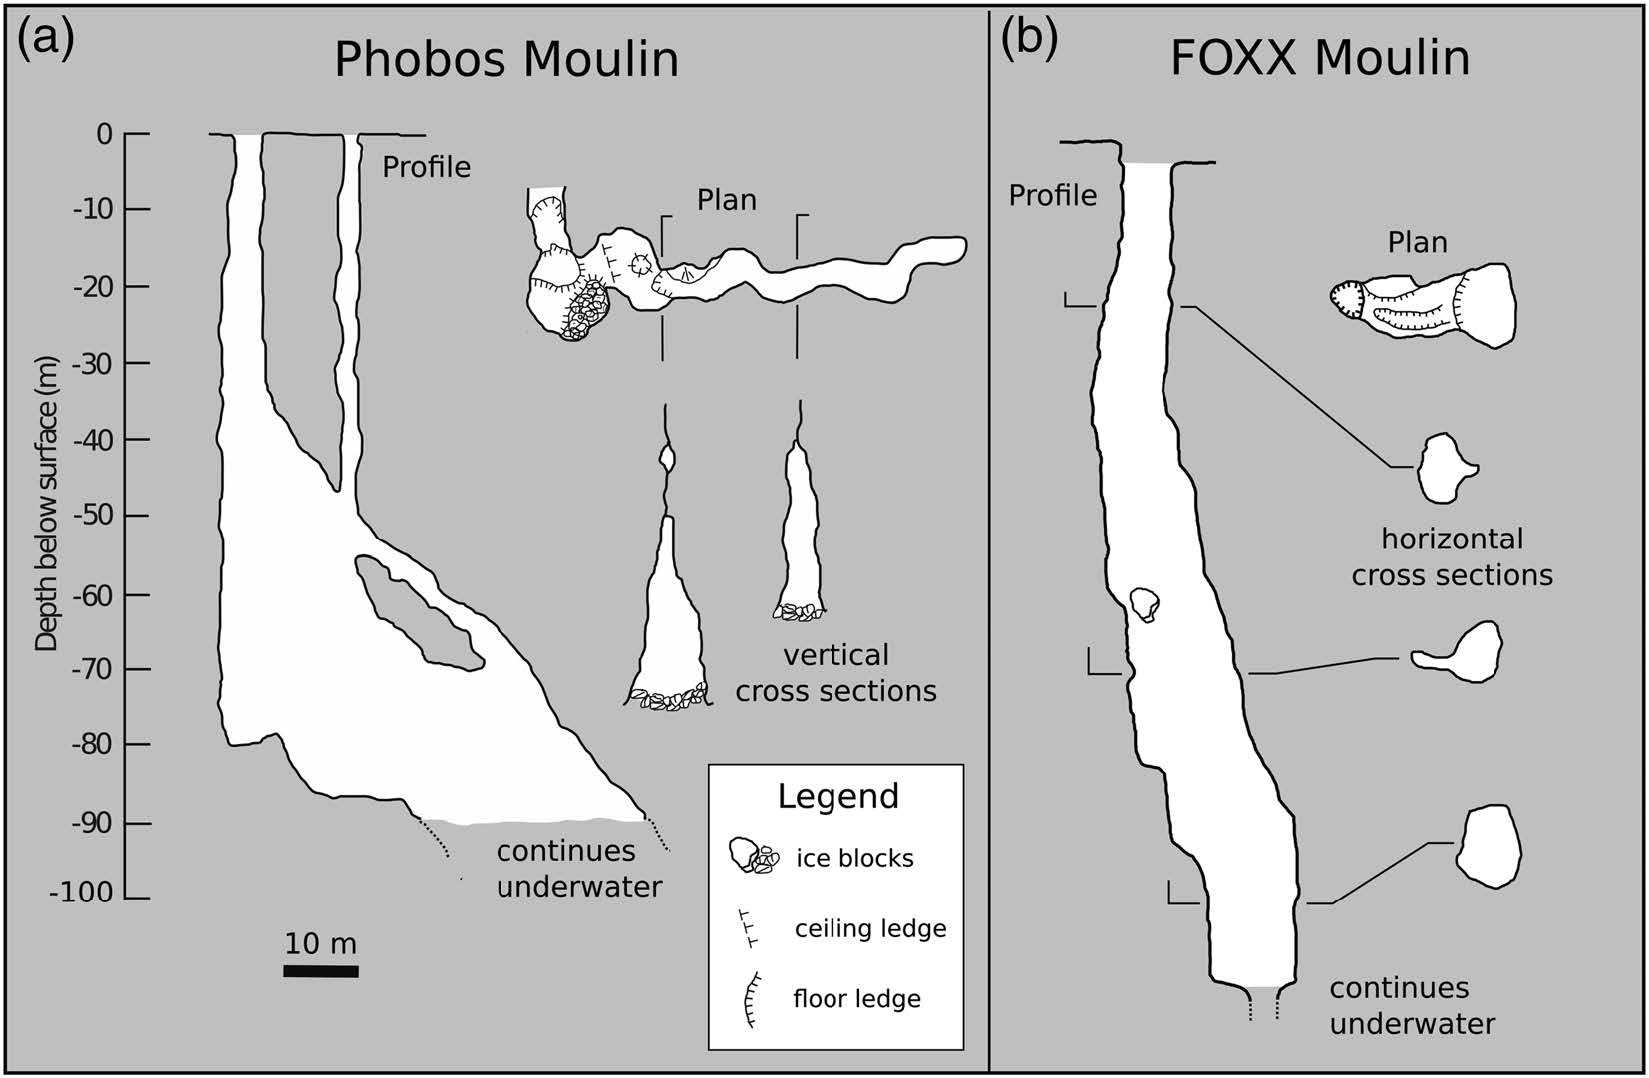

In [4]:
make_all_plots = True
make_directory = True
jeme_goblet, params_jeme_goblet, time_goblet= calc_and_make1plot(jeme,
                                                           z_elevations = [0,380,390,jeme['ice_thickness']],
                                                           moulin_radii = [2,2,5,5],
                                                           initial_subglacial_area = (np.pi*0.3**2)/2,
                                                           make_all_plots = make_all_plots, 
                                                           make_directory = make_directory,
                                                           creep=False,
                                                           elastic_deformation=False,
                                                           melt_below_head=False,
                                                           ice_motion=False,
                                                           dir_name = 'jeme_goblet'
                                                          )



/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Just a cylinder 
Shows that it requires a very large volume to reproduce the head

In [5]:
make_all_plots = True
make_directory = True
jeme_cylinder, params_jeme_cylinder, time_cylinder = calc_and_make1plot(jeme,
                                                           moulin_radii = 5.,
                                                           initial_subglacial_area = (np.pi*0.3**2)/2,
                                                           make_all_plots = make_all_plots, 
                                                           make_directory = make_directory,
                                                           creep=False,
                                                           elastic_deformation=False,
                                                           melt_below_head=False,
                                                           ice_motion=False,
                                                           dir_name = 'jeme_cylinder'
                                                          )

/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Most basic set of parameters
the head is too high

In [2]:
make_all_plots = True
make_directory = True
jeme_brut, params_jeme_brut, time_brut= calc_and_make1plot(jeme,
                                                       initial_subglacial_area = (np.pi*0.3**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       dir_name = 'jeme_brut')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Soft ice -- subglacial channel

In [3]:
make_all_plots = True
make_directory = True
jeme_largeA,params_jeme_largeA, time_jeme_largeA = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots,
                                                    make_directory = make_directory, 
                                                    fluidity_coefficient_SUB = 6e-20,
                                                    dir_name = 'jeme_largeA')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### hard ice

In [6]:
make_all_plots = True
make_directory = True
jeme_smallA,params_jeme_smallA, time_jeme_smallA = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.5**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    fluidity_coefficient_SUB = 6e-26,
                                                           dir_name = 'jeme_smallA')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### more friction in the subglacial channel

In [7]:
make_all_plots = True
make_directory = True
jeme_largef,params_jeme_largef, time_jeme_largef = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.4**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    friction = 1,
                                                           dir_name = 'jeme_largef')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Less friction in the subglacial channel

In [8]:
make_all_plots = True
make_directory = True
jeme_smallf,params_jeme_smallf, time_jeme_smallf = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.2**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory, 
                                                    friction = 0.01,
                                                           dir_name = 'jeme_smallf')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Softer ice moulin

In [9]:
make_all_plots = True
make_directory = True
jeme_largeE,params_jeme_largeE, time_jeme_largeE = calc_and_make1plot(jeme, 
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    creep_factor = 6,
                                                           dir_name = 'jeme_largeE')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Harder ice moulin

In [10]:
make_all_plots = True
make_directory = True
jeme_smallE,params_jeme_smallE, time_jeme_smallE = calc_and_make1plot(jeme,
                                                    initial_subglacial_area = (np.pi*0.3**2)/2,
                                                    make_all_plots = make_all_plots, 
                                                    make_directory = make_directory,  
                                                    creep_factor = 0,
                                                           dir_name = 'jeme_smallE')



/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


# Baseflow

In [11]:
make_all_plots = True
make_directory = True
jeme_bf3,params_jeme_bf3, time_jeme_bf3 = calc_and_make1plot(jeme, 
                                              initial_subglacial_area = (np.pi*1.075**2)/2,
                                              make_all_plots = make_all_plots, 
                                              make_directory = make_directory,  
                                              baseflow = 3,
                                                           dir_name = 'jeme_bf3')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


In [12]:
make_all_plots = True
make_directory = True
jeme_bf3_largeCH,params_jeme_bf3_largeCH, time_jeme_bf3_largeCH = calc_and_make1plot(jeme, 
                                                              initial_subglacial_area = (np.pi*1.2**2)/2,
                                                              make_all_plots = make_all_plots, 
                                                              make_directory = make_directory,  
                                                              baseflow = 3, 
                                                              channel_length = 50000,
                                                           dir_name = 'jeme_bf3_largeCH')


/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


In [13]:
make_all_plots = True
make_directory = True
jeme_bf3_largef,params_jeme_bf3_largef, time_jeme_bf3_largef = calc_and_make1plot(jeme, 
                                                            initial_subglacial_area = (np.pi*1.67**2)/2,
                                                            make_all_plots = make_all_plots, 
                                                            make_directory = make_directory,  
                                                            baseflow = 3, 
                                                            friction = 1,
                                                           dir_name = 'jeme_bf3_largef')

/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:683: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:579: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])
/Users/cctrunz/GitHub/Moulin_Shape/moulin-physical-model-in-python/PyMouSh.py:617: UserWarning: Attempting to set identical left == right == 182.7656365740741 results in singular transformations; automatically expanding.
  axis.set_xlim([self.time_day[idx_min],self.time_day[idx_max]])


### Compare radii

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def extract_radius(moulin_sim):
    radius = np.zeros(len(moulin_sim.dict['head']))
    for idx in np.arange(len(moulin_sim.dict['head'])):
        head = jeme_brut.dict['head'][idx]
        idx_position = find_nearest(moulin_sim.z,head)
        radius[idx] = moulin_sim.listdict[idx]['moulin_radius_major'][idx_position]
    return radius

radius_jeme_brut = extract_radius(jeme_brut)
radius_jeme_bf3 = extract_radius(jeme_bf3)

plt.figure(figsize=(20,5))
plt.plot(jeme_brut.dict['time'] , radius_jeme_brut, label= 'brut')
plt.plot(jeme_bf3.dict['time'] , radius_jeme_bf3, label= 'baseflow 3')
plt.legend()

#fig, ax = plt.subplots()

In [ ]:
jeme_bf3

In [ ]:
make_all_plots = False
make_directory = False
jeme_brut, params_jeme_brut, time_brut= calc_and_make1plot(jeme,
                                                       initial_subglacial_area = (np.pi*0.3**2)/2,
                                                       make_all_plots = make_all_plots, 
                                                       make_directory = make_directory,
                                                       dir_name = 'jeme_brut')
jeme_bf3,params_jeme_bf3, time_jeme_bf3 = calc_and_make1plot(jeme, 
                                              initial_subglacial_area = (np.pi*1.075**2)/2,
                                              make_all_plots = make_all_plots, 
                                              make_directory = make_directory,  
                                              baseflow = 3,
                                                           dir_name = 'jeme_bf3')


#there is too much water for the subglacial drainage system to evacuate, and the subglacial drainage system can't grow fast enough
# during the night there is not enough water coming from above to be able to keep the head high enough and 


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def extract_radius(moulin_sim):
    radius = np.zeros(len(moulin_sim.dict['head']))
    head_all = np.zeros(len(moulin_sim.dict['head']))
    for idx in np.arange(len(moulin_sim.dict['head'])):
        head = moulin_sim.dict['head'][idx]
        idx_position = find_nearest(moulin_sim.z,head)
        radius[idx] = moulin_sim.listdict[idx]['moulin_radius_major'][idx_position]
        head_all[idx] = head
    return radius,head_all

radius_jeme_brut, head_brut = extract_radius(jeme_brut)
radius_jeme_bf3, head_bf3 = extract_radius(jeme_bf3)

plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(jeme_brut.dict['time'] , head_brut, label= 'brut')
plt.plot(jeme_bf3.dict['time'] , head_bf3, label= 'baseflow 3')
plt.legend()
plt.subplot(2,1,2)
plt.plot(jeme_brut.dict['time'] , radius_jeme_brut, label= 'brut')
plt.plot(jeme_bf3.dict['time'] , radius_jeme_bf3, label= 'baseflow 3')
plt.legend()